In [47]:
import pytomography
from pytomography.algorithms import OSEM, MLEM
from pytomography.metadata import ObjectMeta, ProjMeta
from pytomography.projectors import SystemMatrix
from pytomography.likelihoods import NegativeMSELikelihood
import matplotlib.pyplot as plt
import torch

In [48]:
# pytomography.device = 'cuda'
pytomography.device = 'cpu'

In [49]:
M = 3
object_meta = ObjectMeta(dr=(1.5,1.5,1.5), shape=(M,M,M))

In [50]:
# Simulate random events
detector_ids = torch.randint(low=0, high=2*M**2, size=(400,))

print(detector_ids.shape)
detector_ids

torch.Size([400])


tensor([ 0,  4, 16,  6,  3, 12, 11, 11,  9,  9, 14,  7,  5, 13, 10, 17,  5, 16,
         6, 17, 13, 17,  3,  1,  7, 12,  2, 16, 11, 13, 15, 13,  1,  2, 12,  1,
         7, 10,  0, 15,  3,  3,  5,  7,  6,  7, 16,  5,  4,  0, 17,  3,  4,  3,
         7,  2, 14,  8, 15, 14, 12,  8, 10, 13,  8,  6, 12,  8,  4, 17, 12,  2,
         1,  5,  4,  0,  3,  3, 10,  3, 12,  1,  6, 12,  7,  3, 11,  7,  4,  3,
         0,  2, 10,  1, 15, 10,  3,  4, 11, 13,  2,  7, 14, 11, 16,  4, 11, 10,
        10,  3,  8,  7, 13, 17, 14,  5, 15, 10,  8,  2,  4,  4,  2, 11,  1, 11,
         6,  4, 16, 13, 12, 14,  3,  5,  8,  0,  4,  7, 13, 14, 17,  8,  5,  4,
        14,  7,  3,  0,  7,  9,  7, 12,  2,  6, 17,  6, 11, 12, 10, 12, 12,  9,
        10,  6,  1, 14, 12, 14, 14,  5,  0,  8, 15,  7,  3,  8,  4, 10,  2, 13,
         9, 12, 15, 10, 16,  4,  9, 17,  6, 16,  1, 10,  9,  3, 16, 11,  1, 10,
        14,  5, 10,  4,  2, 15,  2, 11,  4, 13,  4,  0,  3,  4, 14, 17,  2, 10,
         8,  7, 11, 15,  5, 10, 14,  0, 

In [51]:
scanner_LUT = torch.cartesian_prod(
    torch.tensor([0,1]), # Angle
    torch.arange(M), # row
    torch.arange(M), # column
)
scanner_LUT

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 1, 0],
        [0, 1, 1],
        [0, 1, 2],
        [0, 2, 0],
        [0, 2, 1],
        [0, 2, 2],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 2],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 2],
        [1, 2, 0],
        [1, 2, 1],
        [1, 2, 2]])

In [52]:
class EXSProjMeta(ProjMeta):
    def __init__(self, M, sensitivity_factor):
        self.M = M
        self.sensitivity_factor = sensitivity_factor
        if (sensitivity_factor.shape[0]!=M)*(sensitivity_factor.shape[1]!=M):
            raise ValueError("sensitivity_factor should have side dimensions M")

In [53]:
M = object_meta.shape[0]
# Note: the sensitivty factor is the same for each projection angle, a single detector is "rotating" between angle 0 and 90
sensitivity_factor = torch.ones((M,M))+0.3*torch.rand((M,M))
proj_meta = EXSProjMeta(M, sensitivity_factor)

In [54]:
sensitivity_factor[*scanner_LUT[detector_ids][:,:2].T]

tensor([1.1644, 1.2781, 1.1481, 1.1994, 1.2781, 1.1346, 1.1311, 1.1311, 1.1311,
        1.1311, 1.1346, 1.1994, 1.2781, 1.1346, 1.1311, 1.1481, 1.2781, 1.1481,
        1.1994, 1.1481, 1.1346, 1.1481, 1.2781, 1.1644, 1.1994, 1.1346, 1.1644,
        1.1481, 1.1311, 1.1346, 1.1481, 1.1346, 1.1644, 1.1644, 1.1346, 1.1644,
        1.1994, 1.1311, 1.1644, 1.1481, 1.2781, 1.2781, 1.2781, 1.1994, 1.1994,
        1.1994, 1.1481, 1.2781, 1.2781, 1.1644, 1.1481, 1.2781, 1.2781, 1.2781,
        1.1994, 1.1644, 1.1346, 1.1994, 1.1481, 1.1346, 1.1346, 1.1994, 1.1311,
        1.1346, 1.1994, 1.1994, 1.1346, 1.1994, 1.2781, 1.1481, 1.1346, 1.1644,
        1.1644, 1.2781, 1.2781, 1.1644, 1.2781, 1.2781, 1.1311, 1.2781, 1.1346,
        1.1644, 1.1994, 1.1346, 1.1994, 1.2781, 1.1311, 1.1994, 1.2781, 1.2781,
        1.1644, 1.1644, 1.1311, 1.1644, 1.1481, 1.1311, 1.2781, 1.2781, 1.1311,
        1.1346, 1.1644, 1.1994, 1.1346, 1.1311, 1.1481, 1.2781, 1.1311, 1.1311,
        1.1311, 1.2781, 1.1994, 1.1994, 

In [55]:
class EXSListmodeProjMeta(ProjMeta):
    def __init__(self, shape, scanner_LUT, detector_ids, sensitivity_factor):
        self.scanner_LUT = scanner_LUT
        self.detector_ids = detector_ids
        self.sensitivity_at_ids = sensitivity_factor[*scanner_LUT[:,1:].T]
        self.shape = shape
        if (sensitivity_factor.shape[0]!=M)*(sensitivity_factor.shape[1]!=M):
            raise ValueError("sensitivity_factor should have side dimensions M")
proj_meta_listmode = EXSListmodeProjMeta((2,M,M), scanner_LUT, detector_ids, sensitivity_factor)

In [56]:
class EXSListmodeSystemMatrix(SystemMatrix):
    def forward(self, object, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        projections = []
        for i, detector_id in enumerate(self.proj_meta.detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                projections.append(object[:,coord[1],coord[2]].sum() *  sensitivity_factor_i) # sum along x
            elif coord[0]==1: # If angle 90:
                projections.append(object[coord[1],:,coord[2]].sum() * sensitivity_factor_i)  # sum along y
        return torch.tensor(projections)

In [57]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
sample_object = torch.rand(object_meta.shape) # object has batch dimension
sample_projections = system_matrix.forward(sample_object)

print(sample_projections.shape) 
sample_projections

torch.Size([400])


tensor([1.1379, 0.8070, 1.3997, 0.7729, 2.1227, 1.2636, 1.0776, 1.0776, 1.2205,
        1.2205, 0.8719, 1.2484, 0.8615, 1.5146, 0.4318, 0.5528, 0.8615, 1.3997,
        0.7729, 0.5528, 1.5146, 0.5528, 2.1227, 1.4017, 1.2484, 1.2636, 1.0682,
        1.3997, 1.0776, 1.5146, 1.6089, 1.5146, 1.4017, 1.0682, 1.2636, 1.4017,
        1.2484, 0.4318, 1.1379, 1.6089, 2.1227, 2.1227, 0.8615, 1.2484, 0.7729,
        1.2484, 1.3997, 0.8615, 0.8070, 1.1379, 0.5528, 2.1227, 0.8070, 2.1227,
        1.2484, 1.0682, 0.8719, 0.5712, 1.6089, 0.8719, 1.2636, 0.5712, 0.4318,
        1.5146, 0.5712, 0.7729, 1.2636, 0.5712, 0.8070, 0.5528, 1.2636, 1.0682,
        1.4017, 0.8615, 0.8070, 1.1379, 2.1227, 2.1227, 0.4318, 2.1227, 1.2636,
        1.4017, 0.7729, 1.2636, 1.2484, 2.1227, 1.0776, 1.2484, 0.8070, 2.1227,
        1.1379, 1.0682, 0.4318, 1.4017, 1.6089, 0.4318, 2.1227, 0.8070, 1.0776,
        1.5146, 1.0682, 1.2484, 0.8719, 1.0776, 1.3997, 0.8070, 1.0776, 0.4318,
        0.4318, 2.1227, 0.5712, 1.2484, 

In [58]:
class EXSListmodeSystemMatrix(SystemMatrix):
    # ----
    # SAME AS ABOVE
    # ----
    def forward(self, object, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        projections = []
        for i, detector_id in enumerate(self.proj_meta.detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                projections.append(object[:,coord[1],coord[2]].sum() *  sensitivity_factor_i) # sum along x
            elif coord[0]==1: # If angle 90:
                projections.append(object[coord[1],:,coord[2]].sum() * sensitivity_factor_i)  # sum along y
        return torch.tensor(projections)
    # ---
    # NEW CODE
    # ---
    def backward(self, projections, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        object = torch.zeros(object_meta.shape)
        projections *= self.proj_meta.sensitivity_at_ids[self.proj_meta.detector_ids]
        for i, detector_id in enumerate(detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            if coord[0]==0: # If angle 0:
                object[:,coord[1],coord[2]] += projections[i]
            elif coord[0]==1: # If angle 90:
                object[coord[1],:,coord[2]] += projections[i]
        return object

In [59]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
sample_object = torch.rand(object_meta.shape) # object has batch dimension
FP = system_matrix.forward(sample_object)
BP = system_matrix.backward(FP)

In [60]:
class EXSListmodeSystemMatrix(SystemMatrix):
    # ----
    # SAME AS ABOVE
    # ----
    def forward(self, object, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        projections = []
        for i, detector_id in enumerate(self.proj_meta.detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                projections.append(object[:,coord[1],coord[2]].sum() *  sensitivity_factor_i) # sum along x
            elif coord[0]==1: # If angle 90:
                projections.append(object[coord[1],:,coord[2]].sum() * sensitivity_factor_i)  # sum along y
        return torch.tensor(projections)
    def backward(self, projections, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        object = torch.zeros(object_meta.shape)
        projections *= self.proj_meta.sensitivity_at_ids[self.proj_meta.detector_ids]
        for i, detector_id in enumerate(detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            if coord[0]==0: # If angle 0:
                object[:,coord[1],coord[2]] += projections[i]
            elif coord[0]==1: # If angle 90:
                object[coord[1],:,coord[2]] += projections[i]
        return object
    # ----
    # NEW CODE
    # ----
    def compute_normalization_factor(self):
        norm_BP = torch.zeros(object_meta.shape)
        # Now we loop through unique detector ids instead
        unique_detector_ids = torch.arange(scanner_LUT.shape[0])
        for i, detector_id in enumerate(unique_detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                norm_BP[:,coord[1],coord[2]] += sensitivity_factor_i
            elif coord[0]==1: # If angle 90:
                norm_BP[coord[1],:,coord[2]] += sensitivity_factor_i
        return norm_BP

In [61]:
sensitivity_factor

tensor([[1.1644, 1.2781, 1.1994],
        [1.1311, 1.1346, 1.1481],
        [1.2142, 1.1189, 1.0945]])

In [62]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
norm_BP = system_matrix.compute_normalization_factor()

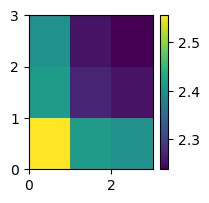

In [63]:
plt.figure(figsize=(2,2))
plt.pcolormesh(norm_BP[:,:,1])
plt.colorbar()

In [64]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
likelihood = NegativeMSELikelihood(system_matrix, scaling_constant=0.01)
reconstruction_algorithm = OSEM(likelihood)

In [65]:
recon = reconstruction_algorithm(n_iters=40)

recon.shape

torch.Size([3, 3, 3])

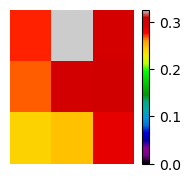

In [66]:
plt.figure(figsize=(2,2))
plt.pcolormesh(recon[:,:,1], vmin=0, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()

In [67]:
class EXSListmodeSystemMatrix(SystemMatrix):
    # ----
    # NEW CODE
    # ----
    def set_n_subsets(self, n_subsets):
        self.n_subsets = n_subsets
        idx = torch.arange(proj_meta_listmode.detector_ids.shape[0])
        self.subset_indices_array = torch.tensor_split(idx, self.n_subsets)
    def get_projection_subset(self, projections, subset_idx):
        # Needs to consider cases where projection is simply a 1 element tensor in the numerator, but also cases of scatter where it is a longer tensor
        if (projections.shape[0]>1)*(subset_idx is not None):
            subset_indices = self.subset_indices_array[subset_idx]
            proj_subset = projections[subset_indices]
        else:
            proj_subset = projections
        return proj_subset
    def get_weighting_subset(self, subset_idx):
        if subset_idx is None:
            return 1
        else:
            # Fraction of events in the subset
            return self.subset_indices_array[subset_idx].shape[0] / proj_meta_listmode.detector_ids.shape[0]
    def forward(self, object, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        projections = []
        if subset_idx is None:
            detector_ids_subset = self.proj_meta.detector_ids
        else:
            detector_ids_subset = self.proj_meta.detector_ids[self.subset_indices_array[subset_idx]]
        for i, detector_id in enumerate(detector_ids_subset):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                projections.append(object[:,coord[1],coord[2]].sum() *  sensitivity_factor_i) # sum along x
            elif coord[0]==1: # If angle 90:
                projections.append(object[coord[1],:,coord[2]].sum() * sensitivity_factor_i)  # sum along y
        return torch.tensor(projections)
    def backward(self, projections, subset_idx = None):
        # There is probably a faster implementation, but I am trying to keep it simple for illustration purposes
        object = torch.zeros(object_meta.shape)
        if subset_idx is None:
            detector_ids_subset = self.proj_meta.detector_ids
        else:
            detector_ids_subset = self.proj_meta.detector_ids[self.subset_indices_array[subset_idx]]
        projections *= self.proj_meta.sensitivity_at_ids[detector_ids_subset]
        for i, detector_id in enumerate(detector_ids_subset):
            coord = self.proj_meta.scanner_LUT[detector_id]
            if coord[0]==0: # If angle 0:
                object[:,coord[1],coord[2]] += projections[i]
            elif coord[0]==1: # If angle 90:
                object[coord[1],:,coord[2]] += projections[i]
        return object
    def compute_normalization_factor(self, subset_idx=None):
        fraction_considered = self.get_weighting_subset(subset_idx)
        norm_BP = torch.zeros(object_meta.shape)
        # Now we loop through unique detector ids instead
        unique_detector_ids = torch.arange(scanner_LUT.shape[0])
        for i, detector_id in enumerate(unique_detector_ids):
            coord = self.proj_meta.scanner_LUT[detector_id]
            sensitivity_factor_i = self.proj_meta.sensitivity_at_ids[detector_id]
            if coord[0]==0: # If angle 0:
                norm_BP[:,coord[1],coord[2]] += sensitivity_factor_i
            elif coord[0]==1: # If angle 90:
                norm_BP[coord[1],:,coord[2]] += sensitivity_factor_i
        return norm_BP * fraction_considered

In [81]:
system_matrix = EXSListmodeSystemMatrix(object_meta=object_meta, proj_meta=proj_meta_listmode)
likelihood = NegativeMSELikelihood(system_matrix, scaling_constant=0.01)
reconstruction_algorithm = OSEM(likelihood)

In [82]:
recon_2subsets = reconstruction_algorithm(n_iters=20, n_subsets=2)
reconstruction_algorithm = OSEM(likelihood)
recon_1subset = reconstruction_algorithm(n_iters=40)

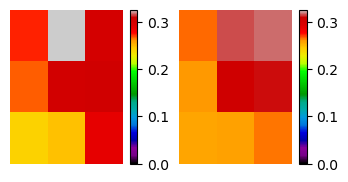

In [83]:
max_value = max([recon_1subset[:,:,1].max().item(), recon_1subset[:,:,1].max().item()])
plt.figure(figsize=(4,2))
plt.subplot(121)
plt.pcolormesh(recon_1subset[:,:,1], vmin=0, vmax=max_value, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(recon_2subsets[:,:,1], vmin=0, vmax=max_value, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()